In [7]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
#%matplotlib notebook

from IPython.display import HTML

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from ssm.hmm import HMM, HSMM
from ssm.util import find_permutation
from ssm.observations import AutoRegressiveObservations, AutoRegressiveDiagonalNoiseObservations
from ssm.observations import Observations
from ssm.stats import diagonal_gaussian_logpdf

# Consider a CoupledARObservation model

For animal 0 (virgin mouse) and animal 1 (mother mouse),

$$x_t^0 \sim N \big(x_{t-1}^0 + \sum_{b=1}^B W_{k,b}^0 f_b^0(x_{t-1}^0, x_{t-1}^1), S^0 \big) \qquad \big| \qquad x_{t-1}^0, x_{t-1}^1, z_t = k$$
$$x_t^1 \sim N \big(x_{t-1}^0 + \sum_{b=1}^B W_{k,b}^1 f_b^1(x_{t-1}^0, x_{t-1}^1), S^1 \big) \qquad \big| \qquad x_{t-1}^0, x_{t-1}^1, z_t = k$$

For the first observation:

$$ x_t^0 \sim N \big(0, S^0_{\text{init}} \big)$$
$$ x_t^1 \sim N \big(0, S^1_{\text{init}} \big)$$

Concatenate two observations into a single observation:

$$x_t = (x_t^0, x_t^1)^T$$

Note that 

- $W$ is a weight matrix of dimension $(K, 2, B)$, deciding the importance of each of B features.

- $f_b^i (x^0, x^1)$ is a feature function (not symmetric) for the animal $i(i=0,1)$.

Now we are considering the following 5 features:

- the distance between two animals

- the distance between animal $i$ and the four locations.

We couls also add other features like velocity, the relative direction (e.g. the angle between two animals' heads).

In [53]:
# Make a constrained AR model

class CoupledARObservations(Observations):
    """
    """

    def __init__(self, K, D, M=0, lags=1, feature_funcs=[]):
        # Initialize most of the parameters
        super(CoupledARObservations, self).__init__(K, D, M)

        # Specify the number of features (basis functions)
        self.K = K
        self.feature_funcs = feature_funcs
        #         self.feature_funcs = [
        #             vector_to_other,
        #             vector_to_nest
        #         ]
        self.B = len(self.feature_funcs)
        
        # Initialize the weights
        self.Ws = .1 * npr.randn(K, 2, self.B)

        # Initialize noise variances
        self._log_sigmasq_init = np.log(np.ones((K, D)))
        self._log_sigmasq = np.log(0.1 * np.ones((K, D)))
    
    @property
    def sigmasq_init(self):
        return np.exp(self._log_sigmasq_init)
    
    
    @property
    def sigmasq(self):
        return np.exp(self._log_sigmasq)

    @property
    def params(self):
        return self.Ws, self._log_sigmasq

    @params.setter
    def params(self, value):
        self.Ws, self._log_sigmasq = value

    def permute(self, perm):
        self.Ws = self.Ws[perm]
        self._log_sigmasq = self._log_sigmasq[perm]

    def initialize(self, datas, inputs=None, masks=None, tags=None, covariances=None, localize=True):
        pass

    def _compute_mus(self, data, input, mask, tag):
        assert np.all(mask), "ARHMM cannot handle missing data"
        K = self.K
        T, D = data.shape
        
        # Split the data by mice
        per_mouse_data = np.split(data, 2, axis=1)

        # Compute the sum of weighted features for each mouse
        mus = np.zeros((T, K, D))
        for n in range(2):
            # Compute mean for this mouse, summing over features
            mu_n = per_mouse_data[n][:-1][:, None, :]
            for b, f in enumerate(self.feature_funcs):
                feature = f(per_mouse_data[n][:-1], per_mouse_data[1 - n][:-1])
                mu_n = mu_n + np.einsum('k,td->tkd', self.Ws[:, n, b], feature)

            # Add this mouse's mean to the total mean
            mus[1:, :, n * D // 2:(n + 1) * D // 2] = mus[1:, :, n * D // 2:(n + 1) * D // 2] + mu_n

        assert mus.shape == (T, K, D)

        return mus

    def log_likelihoods(self, data, input, mask, tag):
        assert np.all(mask), "Cannot compute likelihood of autoregressive obsevations with missing data."
        mus = self._compute_mus(data, input, mask, tag)

        # Compute the likelihood of the initial data and remainder separately
        ll_init = diagonal_gaussian_logpdf(data[0, None, :], self.mu_init self.sigmasq_init)
        ll_ar = diagonal_gaussian_logpdf(data[1:, None, :], mus[1:], self.sigmasq)
        return np.row_stack((ll_init, ll_ar))

    def m_step(self, expectations, datas, inputs, masks, tags, **kwargs):
        K, D, B = self.K, self.D, self.B

        for n in range(2):

            # Collect data for this dimension
            xs, ys, Ezs = [], [], []
            for (Ez, _, _), data, input, mask, tag in zip(expectations, datas, inputs, masks, tags):
                # Split data into arrays for each mouse
                per_mouse_data = np.split(data, 2, axis=1)

                # Compute the features for this mouse
                # Each feature matrix T x D//2 and there are B of them
                features = []
                for b, f in enumerate(self.feature_funcs):
                    features.append(f(per_mouse_data[n][:-1], per_mouse_data[1 - n][:-1]))
                
                assert len(features) == B
                T = data.shape[0]
                assert features[0].shape == (T-1, 2)

                xs.append(np.column_stack(map(np.ravel, features))) # each item is of shape (2*(T-1),B)

                # Compute the outputs, y -- ground-truth
                ys.append(np.ravel(per_mouse_data[n][1:] - per_mouse_data[n][:-1])[:, None])  # each item is of shape (2*(T-1), 1)

                # Weight by the probability of each discrete state
                Ezs.append(Ez[1:])  # each of shape (T-1, K)

            # M step: Fit the weighted linear regressions for each K and D
            J = np.tile(1e-8 * np.eye(B)[None, :, :], (K, 1, 1))  # shape (K, B, B)
            h = np.zeros((K, B, 1))
            for x, y, Ez in zip(xs, ys, Ezs):
                J += np.einsum('tk, ti, tj -> kij', np.repeat(Ez, D // 2, axis=0), x, x)
                # np.repeat(A, 2, axis=0): A=[row1, row2, row3] -> [row1, row1, row2, row2, row3, row3]
                h += np.einsum('tk, ti, td -> kid', np.repeat(Ez, D // 2, axis=0), x, y)

            # Solve for the optimal input weights
            self.Ws[:, n] = np.linalg.solve(J, h)[:, :, 0]
        
        numerator = np.zeros((K, D))
        denominator = np.zeros(K,)
        for (Ez, _, _), data, input, mask, tag in \
                zip(expectations, datas, inputs, masks, tags):
            
            mu = self._compute_mus(data, input, mask, tag)
            mu = mu[1:]
            #assert mu.shape == (T-1, K, D)
            
            data = data[1:]
            #assert data.shape == (T-1, D)
            
            Ez = Ez[1:]
            #assert Ez.shape == (T-1, K)
            
            #assert (data[:,None,:] - mu).shape == (T-1,K,D)
            
            denominator += np.sum(Ez, axis=0)
            #assert denominator.shape == (K, )
            
            numerator += np.einsum('tk, tkd -> kd', Ez, (data[:,None,:]-mu)**2)
            #assert numerator.shape == (K, D)
            
            
        self._log_sigmasq = np.log(numerator) - np.log(denominator)[:,None]
        
        
        
        
    def sample_x(self, z, xhist, input=None, tag=None, with_noise=True):
        D = self.D
        sigmasq_init = np.exp(self._log_sigmasq_init)
        sigmasq = np.exp(self._log_sigmasq)

        if xhist.shape[0] == 0:
            # Sample from the initial distribution
            return np.sqrt(sigmasq_init[z]) * npr.randn(D)
            #return np.sqrt(sigmasq[z]) * npr.randn(D)
        else:
            # Sample from the autoregressive distribution
            per_mouse_data = np.split(xhist, 2, axis=1)
            mu = np.zeros(D)
            for n in range(2):
                # Compute mean for this mouse, summing over features
                mu_n = per_mouse_data[n][-1] # mu at the last time point in the split_x_hist
                for b, f in enumerate(self.feature_funcs):
                    feature = f(per_mouse_data[n][-1], per_mouse_data[1 - n][-1])
                    mu_n = mu_n + self.Ws[z, n, b] * feature

                # Add this mouse's mean to the total mean
                mu[n * D // 2:(n + 1) * D // 2] += mu_n

            return mu + np.sqrt(sigmasq[z]) * npr.randn(D)

        

# load in social behavior data

In [12]:
import joblib 
from Social_Dataset_Class import social_dataset
from Training_Data_Class import training_dataset

datasets_processed = joblib.load('tracedata/all_data_3_1')  # a list of length 30, each is a social_dataset

rendered_data = []
for dataset in datasets_processed:
    session_data = dataset.render_trajectories([3,8])  # list of length 2, each item is an array (T, 2). T = 36000
    rendered_data.append(np.concatenate((session_data),axis = 1)) # each item is an array (T, 4)
trajectories = np.concatenate(rendered_data,axis = 0)  # (T*30, 4)

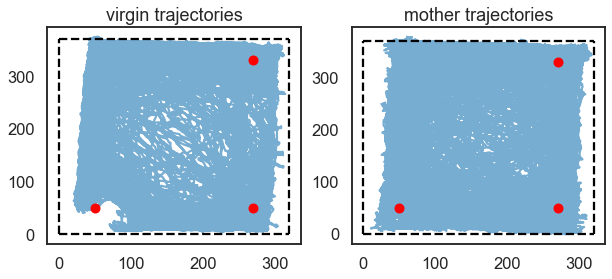

In [108]:
#trajectories = np.concatenate(rendered_data,axis = 1) # (T, 4*30)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
axs[0].plot(trajectories[:,0],trajectories[:,1], alpha=0.6)
axs[0].title.set_text("virgin trajectories")

axs[1].plot(trajectories[:,2],trajectories[:,3], alpha=0.6)
axs[1].title.set_text("mother trajectories")

for ax in axs:
    ax.plot([0, arena_xmax], [0, 0], 'k--')
    ax.plot([0, arena_xmax], [arena_ymax, arena_ymax], 'k--')
    ax.plot([0, 0], [0, arena_ymax], 'k--')
    ax.plot([arena_xmax, arena_xmax], [0, arena_ymax], 'k--')
    ax.plot(nest[0], nest[1], 'ro')
    ax.plot(tank[0], tank[1], 'ro')
    ax.plot(food[0], food[1], 'ro')

In [20]:
len(rendered_data)

30

In [21]:
trajectories.shape

(1080000, 4)

In [22]:
np.min(trajectories, axis=0)

array([20.68859416,  4.78160906, 10.99923861, -1.43330193])

In [24]:
np.max(trajectories, axis=0)

array([314.26579452, 374.9678278 , 317.12118077, 379.03557754])

set arena (image) range to be [0,320], [0,370]

In [87]:
# specify some locations
tank = np.array([50, 50])
food = np.array([270, 50])
nest = np.array([270, 330])

arena_xmax = 320
arena_ymax = 370

# now, specify the model

In [31]:
def vector_to_other(self_loc, other_loc):
    diff = other_loc - self_loc
    return diff / np.linalg.norm(diff, axis=-1, keepdims=True)


def vector_to_fixed_loc(self_loc, other_loc, fixed_loc):
    to_fixed_loc = fixed_loc - self_loc
    return to_fixed_loc / np.linalg.norm(to_fixed_loc, axis=-1, keepdims=True)

In [41]:
K = 5
D = 4
M = 0
N_iters = 50

arhmm = HMM(K, D, M=M, observations="ar")

feature_funcs=[vector_to_other, 
               lambda s, o: vector_to_fixed_loc(s, o, tank), 
               lambda s, o: vector_to_fixed_loc(s, o, nest), 
               lambda s, o: vector_to_fixed_loc(s, o, food),
              ]

In [54]:
car_traj29 = HMM(K, D, M=0, observations=CoupledARObservations(K, D, feature_funcs=feature_funcs))

In [55]:
traj_29 = rendered_data[29]
traj_29.shape

(36000, 4)

In [56]:
car_traj29_lls = car_traj29.fit(traj_29, method="em", num_em_iters=N_iters)

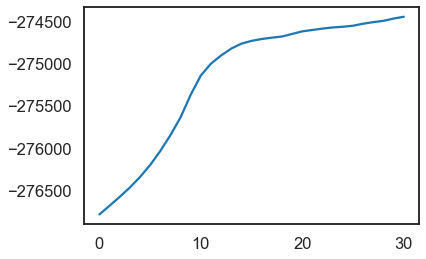

In [57]:
plt.plot(car_traj29_lls[20:])

In [69]:
traj_29[0].reshape(1,4)

array([[292.97772866, 324.81474578,  78.20168543,  75.17859507]])

In [74]:
car_traj29_z = car_traj29.most_likely_states(traj_29)

In [75]:
car_traj29_z[0]

4

In [79]:
z_pre = np.array([car_traj29_z[0]])
x_pre = traj_29[0].reshape(1,4)

In [83]:
duration = 36000 - 1
z_29,x_29 = car_traj29.sample(duration, prefix=(z_pre, x_pre))

Text(0.5, 1.0, 'predicted trajectories from CoupledARHMM')

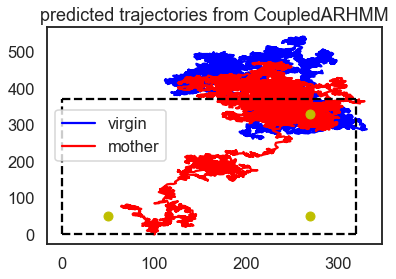

In [111]:
plt.plot(x_29[:, 0], x_29[:, 1], '-b', label='virgin')
plt.plot(x_29[:, 2], x_29[:, 3], '-r', label='mother')
plt.legend()

plt.plot([0, arena_xmax], [0, 0], 'k--')
plt.plot([0, arena_xmax], [arena_ymax, arena_ymax], 'k--')
plt.plot([0, 0], [0, arena_ymax], 'k--')
plt.plot([arena_xmax, arena_xmax], [0, arena_ymax], 'k--')
plt.plot(nest[0], nest[1], 'yo')
plt.plot(tank[0], tank[1], 'yo')
plt.plot(food[0], food[1], 'yo')

plt.title('predicted trajectories from CoupledARHMM')

Text(0.5, 1.0, 'true trajectories from CoupledARHMM')

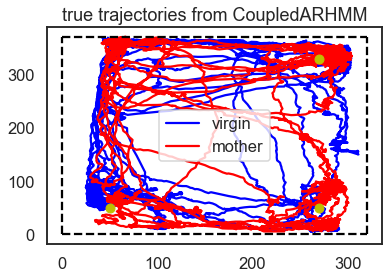

In [110]:
plt.plot(traj_29[:, 0], traj_29[:, 1], '-b', label='virgin')
plt.plot(traj_29[:, 2], traj_29[:, 3], '-r', label='mother')
plt.legend()

plt.plot([0, arena_xmax], [0, 0], 'k--')
plt.plot([0, arena_xmax], [arena_ymax, arena_ymax], 'k--')
plt.plot([0, 0], [0, arena_ymax], 'k--')
plt.plot([arena_xmax, arena_xmax], [0, arena_ymax], 'k--')
plt.plot(nest[0], nest[1], 'yo')
plt.plot(tank[0], tank[1], 'yo')
plt.plot(food[0], food[1], 'yo')
    
plt.title('true trajectories from CoupledARHMM')

